# Interaction Grounded Learning

In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [2]:
class MNISTEnv(object):
    def __init__(self):
        self.mnist = MNIST('./data', False, download=True)
        self.mnist.data = self.mnist.data / 255.0
        self.x_size = 784
        self.y_size = 784
        self.a_size = 10
        self.zeros = (self.mnist.targets == 0).nonzero().view(-1)
        self.ones = (self.mnist.targets == 1).nonzero().view(-1)        
        self.x = None
        self.done = False

    def observe(self):
        self.id = torch.randint(0, self.mnist.data.shape[0], [1])
        self.x = self.mnist.data[self.id]
        self.done = False
        return self.x.view(1, -1)

    def step(self, action):
        if not self.done:
            self.done = True
            if (action == self.mnist.targets[self.id]).all():
                one_idx = self.ones[torch.randint(0, len(self.ones), [1])]
                return self.mnist.data[one_idx].view(1, -1), torch.tensor([1.])
            else:
                zero_idx = self.zeros[torch.randint(0, len(self.zeros), [1])]
                return self.mnist.data[zero_idx].view(1, -1), torch.tensor([0.])
        else:
            raise Warning("Trial already complete.")

In [3]:
class Agent(nn.Module):
    def __init__(self, x_size, a_size, y_size):
        super(Agent, self).__init__()
        self.x_size = x_size
        self.a_size = a_size
        self.y_size = y_size
        self.policy = nn.Sequential(nn.Linear(x_size, a_size), nn.Softmax(-1))
        self.decoder = nn.Sequential(nn.Linear(y_size, 1), nn.Sigmoid())

    def evaluate(self, x, random=False):
        pi = self.policy(x)
        pi_dist = torch.distributions.categorical.Categorical(pi)
        if random:
            a = torch.randint(0, self.a_size, [1])
        else:
            a = pi_dist.sample()
        return a, pi[:,a]

    def decode(self, y):
        r = self.decoder(y)
        return r

In [6]:
env = MNISTEnv()
agent = Agent(env.x_size, env.a_size, env.y_size)
optimizer = optim.Adam(agent.parameters(), lr=1e-3)

epochs = 1000
num_trials = 32

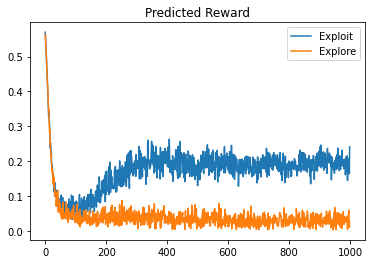

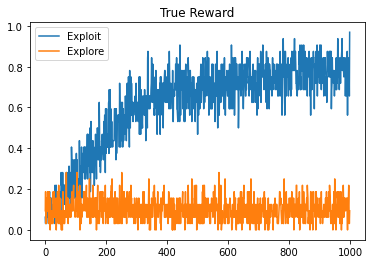

In [7]:
def collect_batch(explore, num_trials):
    experiences = []
    for _ in range(num_trials):
        x = env.observe()
        a, p = agent.evaluate(x, explore)
        y, tr = env.step(a)
        r = agent.decode(y)
        experiences.append([x, a, p, y, r, tr])

    x_s, a_s, p_s, y_s, r_s, tr_s = zip(*experiences)
    x_s = torch.stack(x_s).squeeze(1)
    a_s = torch.stack(a_s).view(-1)
    p_s = torch.stack(p_s).view(-1)
    y_s = torch.stack(y_s).squeeze(1)
    r_s = torch.stack(r_s).view(-1)
    tr_s = torch.stack(tr_s).view(-1)
    return p_s, r_s, tr_s

rewards_exploit = []
rewards_explore = []
for i in range(epochs):
    optimizer.zero_grad()
    exploit_p_s, exploit_r_s, exploit_trs = collect_batch(False, num_trials)
    _, explore_r_s, explore_trs = collect_batch(True, num_trials)

    exploit_adv = (exploit_r_s - torch.mean(exploit_r_s)) / (torch.std(exploit_r_s) + 1e-10)
    exploit_loss = torch.mean(-torch.log(exploit_p_s) * exploit_adv)
    explore_loss = torch.mean(explore_r_s)
    loss = exploit_loss + explore_loss
    loss.backward()
    optimizer.step()
    rewards_exploit.append([torch.mean(exploit_r_s.detach()), torch.mean(exploit_trs.detach())])
    rewards_explore.append([torch.mean(explore_r_s.detach()), torch.mean(explore_trs.detach())])
exploit_pred, exploit_true = zip(*rewards_exploit)
explore_pred, explore_true = zip(*rewards_explore)
plt.plot(exploit_pred, label="Exploit")
plt.plot(explore_pred, label="Explore")
plt.title("Predicted Reward")
plt.legend()
_ = plt.show()
plt.plot(exploit_true, label="Exploit")
plt.plot(explore_true, label="Explore")
plt.title("True Reward")
plt.legend()